In [1]:
import sys
import numpy as np
import pandas as pd
import networkx as nx
import geopandas as gpd
from pathlib import Path
from itertools import product
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from shapely.ops import unary_union

sys.path.append(str(Path.cwd()))
sys.path.append(str(Path.cwd().parent/'scripts'))

from _helpers import generate_color_list
from industry_cluster_analysis import (
    get_costoptimal_network,
    get_simple_costoptimal_network,
    get_partitions,
    plot_network,
    get_plant_capex,
    get_heat_network,
    coords_to_relative_utm,
)

Empty DataFrame
Columns: [source, target]
Index: []


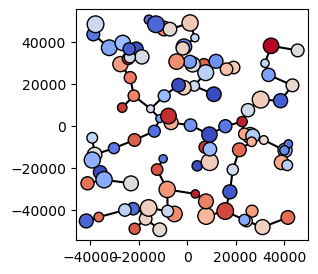

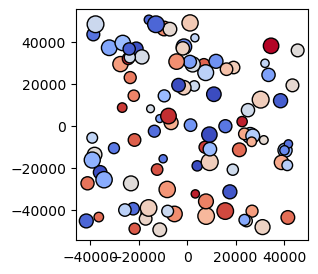

0 613609.8715093487


In [2]:
n = 100
pipe_capex = 1000

sample_coords = np.hstack((
    np.random.uniform(-101, -100, (n, 1)),
    np.random.uniform(38, 39, (n, 1)),
))

sample_coords_meters = coords_to_relative_utm(sample_coords)

sample_temps = np.random.uniform(80, 250, n).tolist()
sample_caps = np.random.uniform(1, 5, n).tolist()

# sample_network, sample_cost = get_costoptimal_network(sample_coords, sample_temps, sample_caps)
T, sample_cost = get_simple_costoptimal_network(
    sample_coords_meters,
    pipe_capex=pipe_capex,
    # sample_temps,
    # sample_caps,
    )

base = nx.Graph()
for i, (x, y) in enumerate(sample_coords_meters):
    base.add_node(
        i,
        pos=(x, y),
        )


for i, j in product(range(n), range(n)):
    if i > j:
        base.add_edge(i, j, weight=np.linalg.norm(np.array(sample_coords_meters[i]) - np.array(sample_coords_meters[j])))

tree = nx.minimum_spanning_tree(base, weight='weight', algorithm='kruskal')

salesman = nx.Graph()
# for i, (x, y) in enumerate(sample_coords):
for i, (x, y) in enumerate(sample_coords_meters):
    salesman.add_node(
        i,
        pos=(x, y),
        )

edgelist = nx.to_pandas_edgelist(T)
print(edgelist)

for i, j in edgelist[['source', 'target']].values:
    # length = V_inv(np.array(sample_coords[i]), np.array(sample_coords[j]))[0]
    salesman.add_edge(i, j, weight=np.linalg.norm(np.array(sample_coords_meters[i]) - np.array(sample_coords_meters[j])))
        # 4 because there is a hot and cold cycle

    # T = nx.minimum_spanning_tree(G, weight='weight', algorithm='kruskal')
plot_network(tree, sample_coords_meters, sample_caps, sample_temps)
plot_network(salesman, sample_coords_meters, sample_caps, sample_temps)

total_length_salesman = 0
for i, j in salesman.edges:
    total_length_salesman += np.linalg.norm(np.array(sample_coords_meters[i]) - np.array(sample_coords_meters[j]))

total_length_tree = 0
for i, j in tree.edges:
    total_length_tree += np.linalg.norm(np.array(sample_coords_meters[i]) - np.array(sample_coords_meters[j]))


print(total_length_salesman, total_length_tree)

In [3]:
shape = gpd.read_file(Path.cwd() /
        'misc_data' /
        'zip_data' /
        'backup_copy' /
        'resources' /
        'US_2021' /
        'bus_regions' /
        'regions_onshore_elec_s_100flex.geojson' /
        'regions_onshore_elec_s_100flex.geojson'
        )

usa_total = gpd.GeoDataFrame(geometry=[unary_union(shape['geometry'])]).set_crs(shape.crs)

In [4]:
def get_dummy_data(do_plot=False):

    n = 500

    t_levels = [90 + i*5 for i in range(40)]

    sites = gpd.GeoDataFrame(
        {
            'demand': np.random.uniform(1, 10, n),
            'temperature': np.random.choice(t_levels, n, replace=True)
            },
        geometry=gpd.points_from_xy(
            # np.random.uniform(-130, -60, 1000),
            # np.random.uniform(25, 50, 1000)
            np.random.uniform(-130, -120, n),
            np.random.uniform(40, 45, n)
            )
        ).set_crs(epsg=4326)

    sites['demand'] *= 50_000

    sites = sites.sjoin(shape, how='inner')

    if do_plot:

        fig, ax = plt.subplots(figsize=(7, 7))

        shape.plot(ax=ax)
        sites.plot(
            ax=ax,
            # color='red',
            column='temperature',
            cmap='magma',
            edgecolor='black',
            markersize=40
            )

        cax = fig.add_axes([0.9, 0.1, 0.03, 0.78])

        norm = plt.Normalize(vmin=sites['temperature'].min(), vmax=sites['temperature'].max())
        sm = plt.cm.ScalarMappable(cmap='magma', norm=norm)
        fig.colorbar(sm, cax=cax)
        cax.set_ylabel('Temperature (°C)')

        ax.set_xlim(-127, -118)
        ax.set_ylim(39, 46)

        plt.show()

    return sites

In [5]:
def get_india_data():

    # df = gpd.read_file('overture_places_heating_demand_disagg_20241008.gpkg')
    df = gpd.read_file('overture_places_heating_demand_disagg_wp_filtered_20241020.gpkg')

    id_cols = [
        'names_primary', 'geometry',
        'industrial_type', 'industrial_sub_type'
    ]

    heating_cols = [
        col for col in df.columns
        if 'Heating (BBtu)' in col and 'total' not in col and '<250' not in col
    ]

    # Melt the dataframe to unpivot heating columns
    df_melted = df.melt(
        id_vars=id_cols,
        value_vars=heating_cols,
        var_name='Temperature Range',
        value_name='Heating Demand (BBtu)'
    )

    # Keep only rows with non-zero heating demand
    df_melted = df_melted[df_melted['Heating Demand (BBtu)'] != 0]

    # Clean up the 'Temperature Range' column
    df_melted['Temperature Range'] = df_melted['Temperature Range'].str.replace(
        'Heating (BBtu), ', '', regex=False
    )

    # Convert BBtu to MWh (1 BBtu = 293.07107 MWh)
    df_melted['Heating Demand (MWh)'] = df_melted['Heating Demand (BBtu)'] * 293.07107

    # Optionally drop the original 'Heating Demand (BBtu)' column
    df_melted = df_melted.drop(columns=['Heating Demand (BBtu)'])

    # Reorder columns if necessary
    df_melted = df_melted[
        id_cols + ['Temperature Range', 'Heating Demand (MWh)']
    ]

    # Cut off rows with heating demand above a certain threshold 
    cutoff = 5000 # MWh; cutoff of 5GWh removes around 1% of total demand, and 50% of datapoints
    # df_melted = df_melted.loc[df_melted['Heating Demand (MWh)'] > cutoff]
    df_melted = df_melted.loc[df_melted['Heating Demand (MWh)'] > cutoff]

    df_melted = df_melted.reset_index(drop=True)

    temp_mapper = {
        '0 to 49°C': 50,
        '50 to 99°C': 100,
        '100 to 149°C': 150,
        '150 to 199°C': 200,
        '200 to 249°C': 250,
        '250 to 299°C': 300,
        '300 to 349°C': 350,
        '350 to 399°C': 400,
        '400 to 449°C': 450,
        '>450°C': 500,
    }

    for old, new in temp_mapper.items():
        df_melted.replace(old, new, inplace=True)
    df_melted.rename(columns={
        'Temperature Range': 'temperature',
        'Heating Demand (MWh)': 'total_demand',
        }, inplace=True)
    df_melted['avg_demand'] = df_melted['total_demand'] / 8760

    df_melted = df_melted.loc[df_melted['temperature'] < 250]
    # df_melted = df_melted.loc[df_melted['temperature'] < 400]

    df_melted['x'] = df_melted['geometry'].x
    df_melted['y'] = df_melted['geometry'].y

    return df_melted


In [6]:
# get_dummy_data().columns
sites = get_india_data()

C:\Users\lukas\AppData\Local\Temp\ipykernel_2164\1200167082.py:64: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_melted.replace(old, new, inplace=True)


In [7]:
sites.sort_values('avg_demand', ascending=False)
print(sites.shape)
sites.loc[sites['avg_demand'] > 10].shape

(1393, 9)


(298, 9)

In [8]:
def round_borehole_capex(cap, one_drill_cap, one_drill_capex):

    fraction = cap / one_drill_cap
    n_wells = round(fraction)

    return one_drill_capex * max(n_wells, fraction) / min(n_wells, fraction)

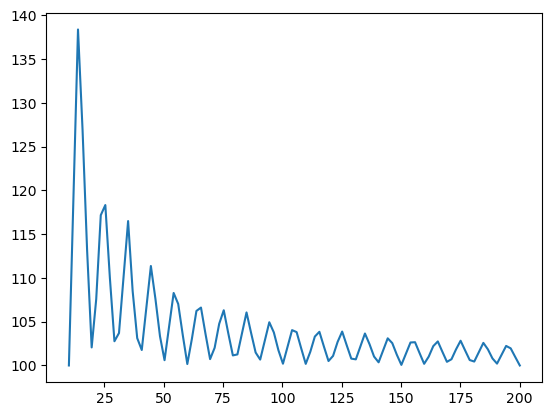

In [9]:
caps = np.linspace(10, 200, 100)

plt.plot(
    caps,
    [round_borehole_capex(cap, 10, 100) for cap in caps]
    )


In [10]:
countries = gpd.read_file('country_shapes.geojson').set_index('cntry_name').loc[[
    'India',
    'Pakistan',
    'Bangladesh',
    'Bhutan',
    'China',
    'Sri Lanka'
    ]]

In [11]:
import tqdm

# from shapely.geometry import MultiPoint
# from sklearn.metrics.pairwise import haversine_distances


threshold_distance_km = 15
threshold_distance_rad = threshold_distance_km / 6371.0

network_capacity_threshold = 9 # MWth
one_drill_capex = 9_200_000 / network_capacity_threshold


# sites = get_dummy_data()

# for index_right in sites.index_right.value_counts().index:
def cluster_sites(
        sites,
        pipe_capex_value=1500,
        do_plot=False,
        save_network_data=False,
        ):

    # ss = sites.loc[sites.index_right == index_right]
    ss = sites.copy()

    sites_np = np.array([ss['geometry'].y, ss['geometry'].x]).T

    db = DBSCAN(
        eps=threshold_distance_rad,
        min_samples=2,
        metric='haversine').fit(np.radians(sites_np))
        # metric='haversine').fit(np.radians(sites_np_meters))
        # ).fit(np.radians(sites_np_meters))

    labels = db.labels_

    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

    sites['cluster'] = labels
    sites['cluster_size'] = list(map(pd.Series(labels).value_counts().get, labels))

    max_cluster_size = 100
    
    # if max_cluster_size is not None:
    #     sites = sites.loc[
    #         (sites.cluster == -1) |
    #         (sites.cluster_size <= max_cluster_size)
    #     ]
    # print(sites.cluster.value_counts())
    # print(sites.cluster_size.sort_values())

    if do_plot:
        _, ax = plt.subplots(1, 1, figsize=(10, 8))
    # shape.plot(ax=ax)

    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

    caps, capex, cluster_size = [], [], []

    save_locs_x, save_locs_y, save_sizes, save_temps, save_cluster = [], [], [], [], []  

    for k, col in tqdm.tqdm(zip(unique_labels, colors)):

        # print(k)

        class_member_mask = (labels == k)
        # print(class_member_mask.sum())

        if max_cluster_size is not None:
            if k != -1 and class_member_mask.sum() > max_cluster_size:
                continue

        xy = sites_np[class_member_mask]
        xy_meters = coords_to_relative_utm(xy)

        size = ss.iloc[class_member_mask]['avg_demand']
        temps = ss.iloc[class_member_mask]['temperature']

        if sum(size) < network_capacity_threshold:
            continue

        if k == -1:
            col = [0, 0, 0, 1]

            for s in size:
                if s < network_capacity_threshold:
                    continue
                else:

                    caps.append(s)

                    plant_capex = (
                        round_borehole_capex(
                            s,
                            network_capacity_threshold,
                            one_drill_capex
                            )
                    )
                    capex.append(plant_capex)

                    # def round_borehole_capex(cap, one_drill_cap, one_drill_capex):
                    #  cluster_size.extend([1] * len(size))
                    cluster_size.append(1)

        else:
            # partitions = get_partitions(list(range(len(xy))))
            partitions = [[tuple(range(len(xy)))]]

            partition_costs = []
            disagg_partition_costs = []

            partition_caps = []
            partition_cluster_sizes = []

            for i, partition in enumerate(partitions):

                n_cost = []
                n_caps = []
                n_cluster_size = []

                ineligible = False
                for n_idx in partition:
                    if sum(size.iloc[list(n_idx)]) < network_capacity_threshold:

                        ineligible = True
                        break
                
                if ineligible:
                    continue

                for n_idx in partition:

                    n_xy = xy[[n_idx]][0]
                    n_xy_meters = xy_meters[[n_idx]][0]
                    n_temp = temps.iloc[list(n_idx)].tolist()
                    n_size = size.iloc[list(n_idx)]
                    n_cluster_size.append(len(n_idx))

                    total_caps, total_cost = get_heat_network(n_xy, n_temp, n_size, pipe_capex=pipe_capex_value)
                    # _, total_cost = get_simple_costoptimal_network(n_xy_meters)

                    total_cost += round_borehole_capex(
                        sum(n_size),
                        network_capacity_threshold,
                        one_drill_capex
                        )

                    n_cost.append(total_cost)
                    n_caps.append(sum(n_size))

                partition_costs.append(sum(n_cost))
                disagg_partition_costs.append(n_cost)
                partition_caps.append(n_caps)
                partition_cluster_sizes.append(n_cluster_size)

            if not len(partition_caps):
                continue

            best_partition = partitions[np.argmin(partition_costs)]
            best_partition_caps = partition_caps[np.argmin(partition_costs)]
            best_disagg_partition_costs = disagg_partition_costs[np.argmin(partition_costs)]
            best_partition_cluster_sizes = partition_cluster_sizes[np.argmin(partition_costs)]

            for ca, co, cl in zip(
                best_partition_caps,
                best_disagg_partition_costs,
                best_partition_cluster_sizes
                ):

                caps.append(ca)
                capex.append(co)
                cluster_size.append(cl)


        if do_plot:
            ax.scatter(
                xy[:, 1],
                xy[:, 0],
                color=tuple(col),
                edgecolor='k',
                alpha=0.7,
                s=size*10*0.5
                )

        save_locs_x.extend(xy[:, 1])
        save_locs_y.extend(xy[:, 0])
        save_sizes.extend(size)
        save_temps.extend(temps)
        save_cluster.extend([k] * len(size))


    if save_network_data:
        gdf = gpd.GeoDataFrame({
            # 'locs_x': save_locs_x,
            # 'locs_y': save_locs_y,
            'sizes': save_sizes,
            'temps': save_temps,
            'cluster': save_cluster,
            'geometry': gpd.points_from_xy(save_locs_x, save_locs_y)
            })
        print(gdf)
        gdf.dropna().to_file(save_network_data, driver='GeoJSON')

    if do_plot:
        countries.plot(ax=ax, color='none', edgecolor='black', linewidth=1, zorder=0)
        countries.loc[['India']].plot(ax=ax, color='grey', edgecolor='black', linewidth=0, zorder=0, alpha=0.2)

        ax.set_title(f'Estimated number of clusters: {n_clusters}')
        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')
        # ax.set_xlim(xy[:, 1].min() - 0.1, xy[:, 1].max() + 0.1)
        # ax.set_ylim(xy[:, 0].min() - 0.1, xy[:, 0].max() + 0.1)

        ax.set_xlim(67, 97)
        ax.set_ylim(7.2, 35.1)

        plt.show()

    return pd.DataFrame({
        'caps': caps,
        'capex': capex,
        'cluster_size': cluster_size
        }).dropna()



87it [00:01, 76.48it/s]c:\Users\lukas\OneDrive\Desktop\projects\pis\pypsa-earth-sec\scripts\industry_cluster_analysis.py:565: RuntimeWarning: invalid value encountered in subtract
  relative_eastings = eastings - centroid_easting
c:\Users\lukas\OneDrive\Desktop\projects\pis\pypsa-earth-sec\scripts\industry_cluster_analysis.py:566: RuntimeWarning: invalid value encountered in subtract
  relative_northings = northings - centroid_northing
171it [00:02, 113.05it/s]c:\Users\lukas\OneDrive\Desktop\projects\pis\pypsa-earth-sec\scripts\industry_cluster_analysis.py:565: RuntimeWarning: invalid value encountered in subtract
  relative_eastings = eastings - centroid_easting
c:\Users\lukas\OneDrive\Desktop\projects\pis\pypsa-earth-sec\scripts\industry_cluster_analysis.py:566: RuntimeWarning: invalid value encountered in subtract
  relative_northings = northings - centroid_northing
181it [00:02, 83.18it/s] 
c:\Users\lukas\miniforge3\envs\pypsa-eur\Lib\site-packages\pyogrio\geopandas.py:662: UserWar

         sizes  temps  cluster                   geometry
0     0.924102     50        1  POINT (70.19001 21.79816)
1     0.924102     50        1  POINT (70.26347 21.73027)
2     0.924102     50        1  POINT (70.27194 21.75381)
3     3.631777    150        1  POINT (70.19001 21.79816)
4     3.631777    150        1  POINT (70.26347 21.73027)
...        ...    ...      ...                        ...
1186  2.163002    200       -1  POINT (85.27424 23.61723)
1187  2.163002    200       -1  POINT (86.11793 23.65851)
1188  2.163002    200       -1    POINT (87.311 22.57551)
1189  2.163002    200       -1  POINT (87.88673 24.77528)
1190  2.163002    200       -1  POINT (91.89987 25.56584)

[1191 rows x 4 columns]


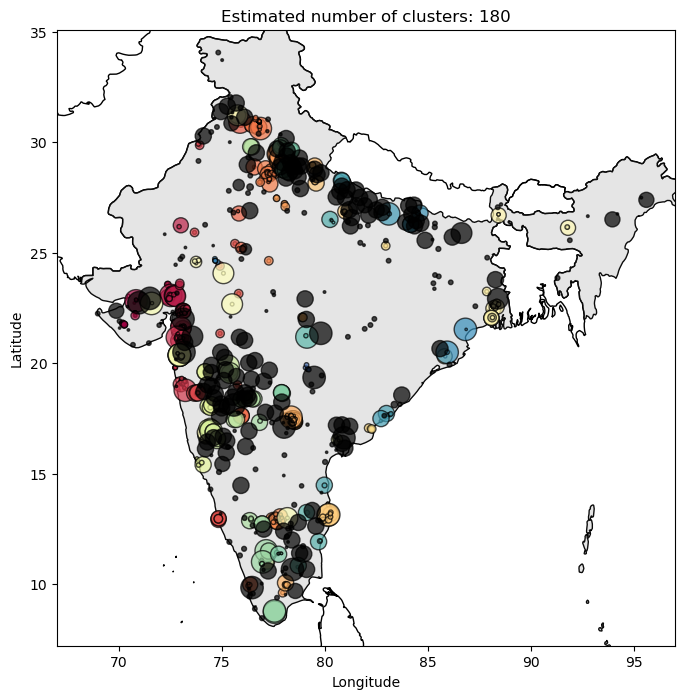

85it [00:01, 90.26it/s]c:\Users\lukas\OneDrive\Desktop\projects\pis\pypsa-earth-sec\scripts\industry_cluster_analysis.py:565: RuntimeWarning: invalid value encountered in subtract
  relative_eastings = eastings - centroid_easting
c:\Users\lukas\OneDrive\Desktop\projects\pis\pypsa-earth-sec\scripts\industry_cluster_analysis.py:566: RuntimeWarning: invalid value encountered in subtract
  relative_northings = northings - centroid_northing
169it [00:01, 115.54it/s]c:\Users\lukas\OneDrive\Desktop\projects\pis\pypsa-earth-sec\scripts\industry_cluster_analysis.py:565: RuntimeWarning: invalid value encountered in subtract
  relative_eastings = eastings - centroid_easting
c:\Users\lukas\OneDrive\Desktop\projects\pis\pypsa-earth-sec\scripts\industry_cluster_analysis.py:566: RuntimeWarning: invalid value encountered in subtract
  relative_northings = northings - centroid_northing
181it [00:01, 95.12it/s] 
c:\Users\lukas\miniforge3\envs\pypsa-eur\Lib\site-packages\pyogrio\geopandas.py:662: UserWar

         sizes  temps  cluster                   geometry
0     0.924102     50        1  POINT (70.19001 21.79816)
1     0.924102     50        1  POINT (70.26347 21.73027)
2     0.924102     50        1  POINT (70.27194 21.75381)
3     3.631777    150        1  POINT (70.19001 21.79816)
4     3.631777    150        1  POINT (70.26347 21.73027)
...        ...    ...      ...                        ...
1186  2.163002    200       -1  POINT (85.27424 23.61723)
1187  2.163002    200       -1  POINT (86.11793 23.65851)
1188  2.163002    200       -1    POINT (87.311 22.57551)
1189  2.163002    200       -1  POINT (87.88673 24.77528)
1190  2.163002    200       -1  POINT (91.89987 25.56584)

[1191 rows x 4 columns]


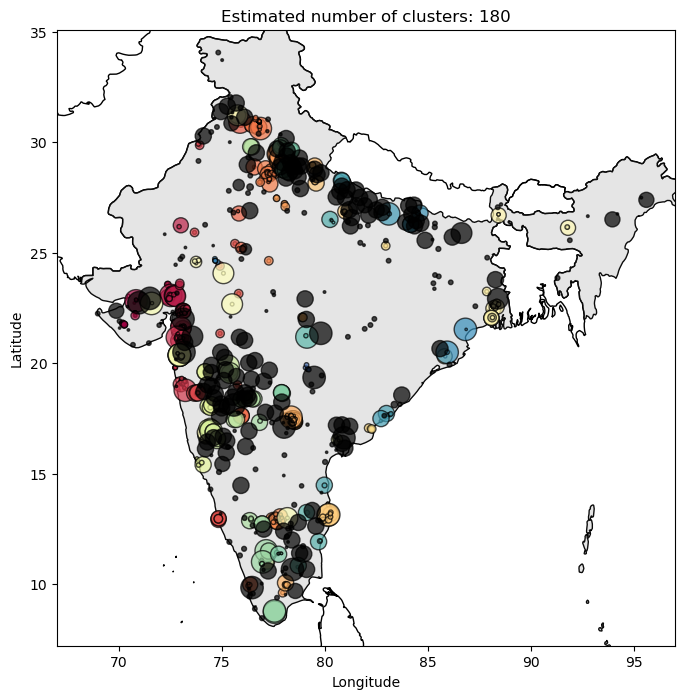

82it [00:00, 95.94it/s]c:\Users\lukas\OneDrive\Desktop\projects\pis\pypsa-earth-sec\scripts\industry_cluster_analysis.py:565: RuntimeWarning: invalid value encountered in subtract
  relative_eastings = eastings - centroid_easting
c:\Users\lukas\OneDrive\Desktop\projects\pis\pypsa-earth-sec\scripts\industry_cluster_analysis.py:566: RuntimeWarning: invalid value encountered in subtract
  relative_northings = northings - centroid_northing
171it [00:01, 118.13it/s]c:\Users\lukas\OneDrive\Desktop\projects\pis\pypsa-earth-sec\scripts\industry_cluster_analysis.py:565: RuntimeWarning: invalid value encountered in subtract
  relative_eastings = eastings - centroid_easting
c:\Users\lukas\OneDrive\Desktop\projects\pis\pypsa-earth-sec\scripts\industry_cluster_analysis.py:566: RuntimeWarning: invalid value encountered in subtract
  relative_northings = northings - centroid_northing
181it [00:01, 97.93it/s] 
c:\Users\lukas\miniforge3\envs\pypsa-eur\Lib\site-packages\pyogrio\geopandas.py:662: UserWar

         sizes  temps  cluster                   geometry
0     0.924102     50        1  POINT (70.19001 21.79816)
1     0.924102     50        1  POINT (70.26347 21.73027)
2     0.924102     50        1  POINT (70.27194 21.75381)
3     3.631777    150        1  POINT (70.19001 21.79816)
4     3.631777    150        1  POINT (70.26347 21.73027)
...        ...    ...      ...                        ...
1186  2.163002    200       -1  POINT (85.27424 23.61723)
1187  2.163002    200       -1  POINT (86.11793 23.65851)
1188  2.163002    200       -1    POINT (87.311 22.57551)
1189  2.163002    200       -1  POINT (87.88673 24.77528)
1190  2.163002    200       -1  POINT (91.89987 25.56584)

[1191 rows x 4 columns]


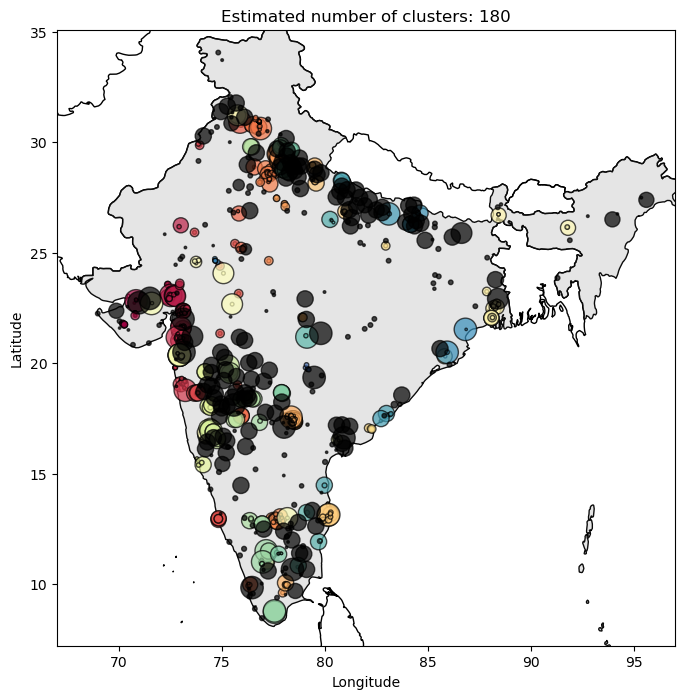

In [16]:
data = list()
for i, capex in enumerate([1000, 1500, 2000]):

    region_df = cluster_sites(
        sites,
        pipe_capex_value=capex,
        do_plot=True,
        save_network_data=f'network_clustering_layout.geojson'
        ).sort_values('capex')
    data.append(region_df)

In [17]:
def generate_color_list(n):
    # Use a colormap to generate n distinct colors
    cmap = plt.get_cmap('Accent')
    colors = [cmap(i / n) for i in range(n)]
    return colors

C:\Users\lukas\AppData\Local\Temp\ipykernel_2164\4240310581.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  region_df['cumcap'] = region_df['caps'].cumsum()
C:\Users\lukas\AppData\Local\Temp\ipykernel_2164\4240310581.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  region_df['cumcap'] = region_df['caps'].cumsum()
C:\Users\lukas\AppData\Local\Temp\ipykernel_2164\4240310581.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

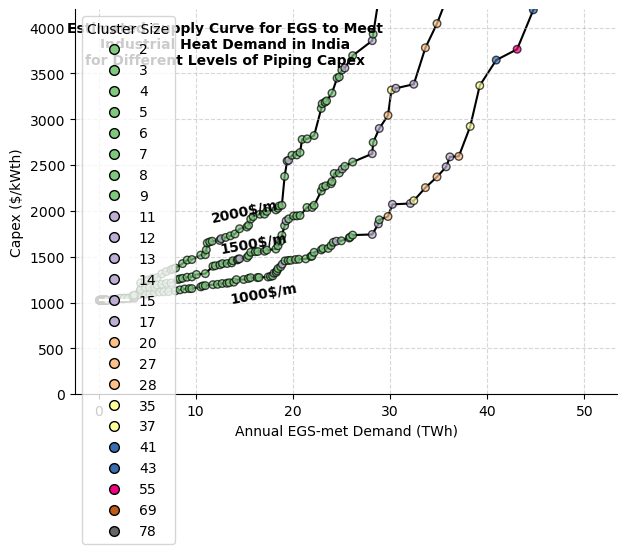

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))


for i, region_df in enumerate(data):

    region_df = region_df.loc[region_df['cluster_size'] > 1]

    # region_df = cluster_sites(sites).sort_values('capex')
    region_df['cumcap'] = region_df['caps'].cumsum()


    ax.plot(region_df['cumcap']*8760*1e-6, region_df['capex']*1e-3, zorder=1, color='black')

    color_list = generate_color_list(max(region_df['cluster_size']) + 1)
    c = [color_list[i] for i in region_df['cluster_size']]

    ax.scatter(
        region_df['cumcap']*8760*1e-6,
        region_df['capex']*1e-3,
        c=c,
        s=30,
        edgecolor='k',
        zorder=2,
        alpha=0.7
        )
    ax.set_xlabel('Annual EGS-met Demand (TWh)')
    ax.set_ylabel('Capex ($/kWth)')

    # ax.set_xlim(-10, 770)
    # ax.set_ylim(500, 1040)

    ax.grid(True, linestyle='--', alpha=0.5)

    labels = region_df['cluster_size'].unique()
    handles = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_list[i], markersize=7,
                markeredgecolor='k', label=f'{i} sites')
            for i in labels]
    
    labels = pd.DataFrame({
        'labels': labels,
        'handles': handles
        }).sort_values('labels')

    if i == 0:
        ax.legend(labels['handles'], labels['labels'], title='Cluster Size', loc='upper left')

# ax.text()
# rotation=slope_1000,
ax.text(15, 2000, '2000$/m', color='k', rotation=12, va='center', ha='center', fontweight='bold')
ax.text(16, 1650, '1500$/m', color='k', rotation=10, va='center', ha='center', fontweight='bold')
ax.text(17, 1100, '1000$/m', color='k', rotation=10, va='center', ha='center', fontweight='bold')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.text(
    13, 3600,
    'Estimated Supply Curve for EGS to Meet\nIndustrial Heat Demand in India\nfor Different Levels of Piping Capex',
    fontsize=10,
    fontweight='bold',
    ha='center'
)

ax.set_ylim(0, 4200)

plt.show()

In [151]:
region_df

,caps,capex,cluster_size,cumcap
15,9.034655,3.078475e+06,2,9.034655
50,9.034655,3.078475e+06,2,18.069310
63,9.034655,3.078475e+06,2,27.103965
38,9.034655,3.078475e+06,2,36.138620
16,9.034655,3.078475e+06,2,45.173275
...,...,...,...,...
122,4.326004,4.535255e+06,2,2687.431501
100,4.218933,4.554483e+06,3,2691.650434
137,4.326004,4.558663e+06,2,2695.976439
130,4.326004,4.567348e+06,2,2700.302443


In [5]:

# Example usage
if __name__ == "__main__":
    # List of coordinates (longitude, latitude)
    coords = [
        (-122.4194, 37.7749),  # San Francisco
        (-118.2437, 34.0522),  # Los Angeles
        (-121.8863, 37.3382),  # San Jose
        (-117.1611, 32.7157),  # San Diego
        (-119.4179, 36.7783),  # California centroid
    ]

    relative_coords = coords_to_relative_utm(coords)

    # print(f"UTM Zone: {utm_zone}, Hemisphere: {hemisphere}")
    print("Coordinates relative to centroid (in meters):")
    for i, (rel_e, rel_n) in enumerate(relative_coords):
        print(f"Point {i + 1}: Easting: {rel_e:.2f} km, Northing: {rel_n:.2f} m")

Coordinates relative to centroid (in meters):
Point 1: Easting: -221873.95 km, Northing: 236804.51 m
Point 2: Easting: 140778.27 km, Northing: -189248.98 m
Point 3: Easting: -177405.93 km, Northing: 185713.84 m
Point 4: Easting: 240466.98 km, Northing: -338108.87 m
Point 5: Easting: 39787.84 km, Northing: 115115.31 m


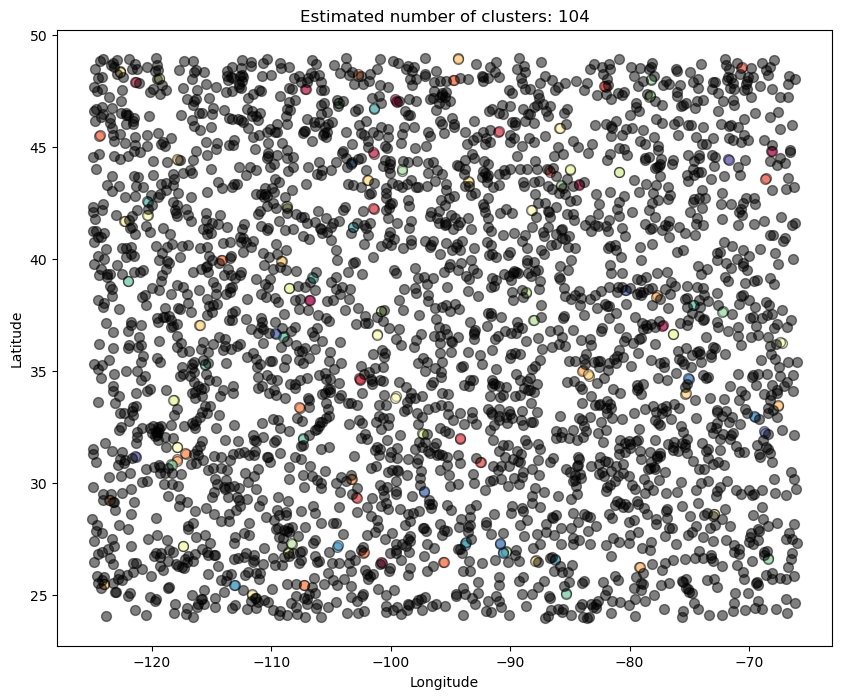

In [16]:
import numpy as np
from sklearn.cluster import DBSCAN
from geopy.distance import great_circle
import matplotlib.pyplot as plt

latitudes = np.random.uniform(low=24, high=49, size=3000)
longitudes = np.random.uniform(low=-125, high=-66, size=3000)
sites = np.vstack((latitudes, longitudes)).T

# Define the maximum distance for a cluster in kilometers
threshold_distance_km = 10

# Convert the threshold distance from kilometers to radians (for use with geodesic distance)
threshold_distance_rad = threshold_distance_km / 6371.0  # Earth's radius in km

# Perform DBSCAN clustering based on geographical distance
db = DBSCAN(eps=threshold_distance_rad, min_samples=2, metric='haversine').fit(np.radians(sites))
labels = db.labels_

# Number of clusters (ignoring noise if any)
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

# Plotting the results (not geographically accurate but illustrative)
plt.figure(figsize=(10, 8))
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        col = [0, 0, 0, 1]  # Black for noise

    class_member_mask = (labels == k)
    xy = sites[class_member_mask]
    plt.scatter(xy[:, 1], xy[:, 0], color=tuple(col), edgecolor='k', s=50, alpha=0.5)

plt.title(f'Estimated number of clusters: {n_clusters}')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


In [15]:
import geopandas as gpd
import pandas as pd
import networkx as nx
from shapely.geometry import LineString, MultiLineString

def process_geojson(input_file, output_file):
    # Load the GeoJSON file into a GeoDataFrame
    gdf = gpd.read_file(input_file)

    # Project to a suitable coordinate reference system for accurate distance calculations
    gdf = gdf.to_crs(epsg=3857)

    # Initialize the 'row_type' column
    gdf['row_type'] = 'site'

    # Get unique clusters excluding -1
    clusters = gdf[gdf['cluster'] != -1]['cluster'].unique()

    for cluster_id in clusters:
        # Subset the GeoDataFrame for the current cluster
        cluster_points = gdf[gdf['cluster'] == cluster_id]
        points = list(cluster_points.geometry)

        # Create a complete graph
        G = nx.Graph()

        # Add nodes to the graph
        for idx, point in enumerate(points):
            G.add_node(idx, geometry=point)

        # Add weighted edges to the graph based on distances
        for i in range(len(points)):
            for j in range(i + 1, len(points)):
                p1 = points[i]
                p2 = points[j]
                distance = p1.distance(p2)
                G.add_edge(i, j, weight=distance)

        # Compute the minimum spanning tree
        mst = nx.minimum_spanning_tree(G)

        # Create LineStrings for each edge in the MST
        lines = [LineString([points[u], points[v]]) for u, v in mst.edges()]

        # Combine LineStrings into a MultiLineString
        mst_geometry = MultiLineString(lines)

        # Prepare a new row for the GeoDataFrame
        new_row = {
            'cluster': cluster_id,
            'geometry': mst_geometry,
            'row_type': 'network'
        }

        # Include other columns with NaN values
        for col in gdf.columns:
            if col not in new_row:
                new_row[col] = pd.NA

        # Create a new GeoDataFrame for the new row
        new_gdf = gpd.GeoDataFrame([new_row], columns=gdf.columns, crs=gdf.crs)

        # Append the new row to the original GeoDataFrame
        gdf = pd.concat([gdf, new_gdf], ignore_index=True)

    # Optionally, reproject back to the original CRS if needed
    gdf = gdf.to_crs(epsg=4326)

    # Save the updated GeoDataFrame to a new GeoJSON file
    gdf.to_file(output_file, driver='GeoJSON')

if __name__ == "__main__":
    input_geojson = 'network_clustering_layout.geojson'  # Replace with your input file path
    output_geojson = 'network_clustering_layout_with_pipes.geojson'  # Replace with your desired output file path
    process_geojson(input_geojson, output_geojson)


C:\Users\lukas\AppData\Local\Temp\ipykernel_2164\593166764.py:64: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  gdf = pd.concat([gdf, new_gdf], ignore_index=True)
C:\Users\lukas\AppData\Local\Temp\ipykernel_2164\593166764.py:64: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  gdf = pd.concat([gdf, new_gdf], ignore_index=True)
C:\Users\lukas\AppData\Local\Temp\ipykernel_2164\593166764.py:64: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a futu

In [134]:
output_geojson

'network_clustering_layout_with_pipes.geojson'